# HW7: HMM


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Eric Weiner

**Names of any collaborators:** Sarah Wu, Elyssa Hofgard

*Due: 11:59pm Monday, May 24, 2021 via GradeScope*

---

In this homework we will learn how to fit a Hidden Markov Model. See the slides for Lap 7 ([Part 1](https://github.com/slinderman/stats271sp2021/blob/main/slides/lap7_hmms.pdf) and [Part 2](https://github.com/slinderman/stats271sp2021/blob/main/slides/lap7_hmms_b.pdf)) for more information on this model.

The data set we will be working with consists of player position data from a 2015-2016 NBA game between the Golden State Warriors and the Cleveland Cavaliers. This game will be broken into a couple hundred "events" (continuous plays in the game), and we will model this as a 20-dimensional HMM (the $x,y$ co-ordinates of the 10 players), where each event is a conditionally independent realization of the HMM. For simplicity, we will ignore the position of the ball and ignore plays that include inbounding (when there are only 9 players on the court).

Mathematically, let $\mathbf{x}_t^{(v)} \in \mathbb{R}^{20}$ denote the combined positions of all 10 players at time step $t$ of the $i$-th event, and let $\mathbf{x}_{1:T_i}^{(i)} = (\mathbf{x}_1^{(v)}, \ldots, \mathbf{x}_{T_v}^{(v)})$ denote the full sequence of positions for the $v$-th event, where $T_v$ is the number of time frames. Likewise, let $z_{1:T_v}^{(v)} = (z_1^{(v)}, \ldots, z_{T_v}^{(v)})$ denote the sequence of discrete states for the $i$-th event. 
We've downsampled the data to about 1.5fps or 0.66sec/time frame. 

The joint distribution of the complete dataset is,
\begin{align}
p(\{(z_{1:T_v}^{(v)}, \mathbf{x}_{1:T_v}^{(v)}\}_{v=1}^V \mid \Theta) 
&= \prod_{v=1}^V p(z_{1:T_v}^{(v)}, \mathbf{x}_{1:T_v}^{(v)} \mid \Theta) \\
&= \prod_{v=1}^V \left[p(z_1^{(v)} \mid \Theta) \prod_{t=2}^{T_v} p(z_{t}^{(v)} \mid z_{t-1}^{(v)} , \Theta)  \prod_{t=1}^{T_v} p(\mathbf{x}_{t}^{(v)} \mid z_{t}^{(v)}, \Theta) \right]
\end{align}
Your goal is to find the parameters $\Theta$ that maximize the marginal likelihood of the data by using EM. Then you'll use cross validation, holding out a random subset of events, to determine the number of discrete states. Finally, you'll visualize the inferred states in terms of the distribution over each player's location on the court.

**Note**: We've provided the data in both a numpy array and a CSV file. The first column of the CSV file includes the event index and the remaining columns include the player positions.

In [334]:
import numpy as np

event_data_np = np.load('/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 7/event_data.npy', 
                     allow_pickle = True)

event_data = list(event_data_np)


print("number of events: ", len(event_data))
print("average event length: ", np.mean([len(xs) for xs in event_data]))
print("total number of time steps", np.sum([len(xs) for xs in event_data]))

number of events:  260
average event length:  16.515384615384615
total number of time steps 4294


# Part 1: Fit a HMM to the model

## Problem 1a: Implement EM for a Gaussian HMM
To get you started, we've provided a few function headers that you might find helpful.

**Note:** To keep it simple, you can assume a fixed, uniform initial distribution and a fixed transition matrix of the form \begin{align}
P_{ij} &= \begin{cases}
1-\epsilon & \text{if } i=j \\
\frac{\epsilon}{K-1} & \text{o.w.}
\end{cases}
\end{align}
for small-ish $\epsilon$.

In [530]:
from scipy.stats import dirichlet
from scipy.stats import multivariate_normal
from numpy import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import multinomial

In [72]:
import pandas as pd 

# Load the data
df = pd.read_csv('/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 7/event_data.csv', header = None,
                index_col = 0)
dfnp = df.to_numpy()

since the elbow is at 3 clusters, we choose 3 clusters

In [764]:
###initializer of means and covs based on specified number of classes

def initial_means_covs(K):
    kmeans_labels = np.reshape(KMeans(n_clusters = K).fit(dfnp).labels_, (4294,1))
    new_array = np.concatenate((kmeans_labels, dfnp), axis = 1)
    df_labels_and_data = pd.DataFrame(new_array)
    cluster_means = []
    cluster_covs = []
    for i in range(K):
        cluster_i = df_labels_and_data.loc[df_labels_and_data[0] == i].to_numpy()
        c_cov_i = np.cov(cluster_i[:,1:].T)
        c_mean_i = np.mean(cluster_i[:,1:], axis = 0)
        cluster_means.append(c_mean_i)
        cluster_covs.append(c_cov_i)
    return cluster_means, cluster_covs


In [767]:
##makes the transition matrix

def t_matrix(K,eps):
    diag_entry = 1 - eps 
    starter = np.ones((K,K))
    starter = starter*(eps/(K-1))
    np.fill_diagonal(starter, diag_entry)
    return starter

In [1025]:
#### Calculating  likelihoods

def likelihood(data, K, means, covariances):
    lh = []
    events = np.shape(data)[0]
    for j in range(events):
        rows = np.shape(data[j])[0]
        next_lh = np.zeros((rows,K)) 
        for i in range(K):
            means[i] = np.reshape(means[i],(20,))
            next_lh[:,i] = multivariate_normal.pdf(data[j], mean=means[i], cov=covariances[i],
                                                   allow_singular = True)
        lh.append(next_lh)
    return lh    

In [1059]:
def forward_pass(initial_dist, transition_matrix, log_likelihoods,K):

    T = len(log_likelihoods)
    
    alphas = np.zeros((T, K))
    alphas[0,:] = np.reshape(initial_dist.T, (len(initial_dist.T)))
    for i in range(1,T):
        
        llh_prev_alpha = np.multiply(alphas[i-1,:],log_likelihoods[i-1,:]).T
        
        A_inv = 1/np.sum(llh_prev_alpha)
        alphas[i,:] = A_inv*np.dot(transition_matrix,llh_prev_alpha)
    
    return alphas
    


def marginal_ll(alphas, log_likelihoods):
 
    alphas = list_to_array(alphas)
    lhs = np.concatenate(log_likelihoods)
    prod = np.multiply(alphas, lhs)
    A = np.sum(prod, axis = 1)
    #print(A)
    marginal_ll = np.sum(np.log(A))
    
    return marginal_ll
    


def backward_pass(transition_matrix, log_likelihoods,K):

    T = len(log_likelihoods)
    
    betas = np.zeros((T, K))
    betas[-1,:] = np.ones((1,K))
    for i in range(1,T):
        
        llh_next_beta = np.multiply(betas[-i,:],log_likelihoods[-i,:]).T
    
        betas[-(i+1),:] = np.dot(transition_matrix,llh_next_beta)
    
    return betas
    


def e_step(data, initial_dist, trans_matrix, means, covs, K):
    Xdata = list_to_array(data)
    events = len(data)
    new_lh = likelihood(data, K, means, covs)
    
    alphas = []
    betas = []
   
    for i in range(events):
        data_step_i = event_data[i]
        
        
        ll_step_i = new_lh[i]
        
        new_alphas_step_i = forward_pass(initial_dist, trans_matrix, ll_step_i,K)
        new_betas_step_i = backward_pass(trans_matrix, ll_step_i,K)
        
        alphas.append(new_alphas_step_i)
        betas.append(new_betas_step_i)
      
    
    
    next_marginal_ll = marginal_ll(alphas, new_lh)
    alphas = np.concatenate(alphas)
    betas = np.concatenate(betas)
    new_lh = np.concatenate(new_lh)
    num = np.multiply(alphas, new_lh, betas)
    denom = np.reshape(np.sum(num, axis =1), (np.shape(alphas)[0],1))
    expectations = np.multiply(num, 1/denom)
       
    
   
    return expectations, next_marginal_ll
    


def m_step(data, expectations,K):

    ##calculating number of total in each state
    def states(expectations,K):
        total_states = np.sum(expectations, axis=0)
        
        return(total_states)
            
    ## calculating psi 1 for all K classes
    def psi_1(data, expectations):
        psi1 = []
        new_exp = expectations
        Xdata = np.concatenate(data)
        mult_data = Xdata[:,:, np.newaxis]@Xdata[:, np.newaxis,:]
        first = new_exp[:,:, np.newaxis, np.newaxis]
        second = mult_data[:, np.newaxis,:,:]
        psi_1 = np.sum((first*second),axis =0)
    
        return psi_1
   
    
    ## calculating psi 2 for all k classes
    def psi_2(data, expectations):
        psi2  = expectations.T@np.concatenate(data)
        
        return psi2

    
    ##calculating new means
    def new_b(psi2, psi3):
        
        inv_psi3 = 1/psi3
        b = np.multiply(inv_psi3, psi2.T).T
        
        return b
    
    ##calculating new covariance matrices
    def new_Q(N, psi1, psi2, psi3):
        inv_N = 1/N
        inv_psi3 = 1/psi3
        psi2_sq = psi2[:,:, np.newaxis]@psi2[:, np.newaxis,:]
        
        first = np.multiply(inv_psi3[:,np.newaxis, np.newaxis],psi2_sq)
        
        Q = inv_N[:,np.newaxis, np.newaxis]*(psi1 - first)
        
        return Q

    
    psi1 = psi_1(data, expectations)
    psi2 = psi_2(data, expectations)
    psi3  = states(expectations,K)
    nstates = psi3
    
    bs = new_b(psi2, psi3)
    Qs = new_Q(nstates, psi1, psi2, psi3)
    
    return bs, Qs
    
def fit_hmm(data, num_states):

    K = num_states
    iter  = 75
    initial_dist = dirichlet.rvs(np.ones(K))
    trans_matrix = t_matrix(K,0.85)
    marginal_likelihoods = []
    means, covs = initial_means_covs(K)
    
    for i in range(iter):
        #print(f"we are on loop {i}")
        exp, nml = e_step(data, initial_dist, trans_matrix, means, covs,K)
       
        bs, Qs = m_step(data, exp,K)
        
        marginal_likelihoods.append(nml)
        
        means = bs
        reg = 1000*np.eye(20)
        covs = Qs + reg[np.newaxis,:]
    return marginal_likelihoods, bs, Qs
#graphing, bees, qees = fit_hmm(event_data, 30)
#plt.plot(graphing)

In [550]:
def list_to_array(unpack):

    data_array = np.zeros((1,np.shape(unpack[0])[1]))
    events = np.shape(unpack)[0]
    for i in range(events):
        data_array = np.concatenate((data_array, unpack[i]), axis = 0)
    data_array = data_array[1:,:]
    return data_array
np.shape(list_to_array(testing))

(4294, 3)

## Problem 1b: Cross-validation
Holding out 20% of the events, use cross-validation to determine the optimal number of latent states to use. Plot held-out likelihood vs number of states. For simplicity/time saving purposes, train and cross-validate your model using $[10,20,30,40,50]$ hidden states.


In [924]:
from sklearn.model_selection import train_test_split

event_data_train, event_data_test = train_test_split(event_data, test_size=0.2, random_state=0)

In [1035]:
#hidden_states = np.array([20])
#held_out_LH = []
#for i in hidden_states:
  
ml_10, means_10, covs_10 = fit_hmm(event_data_train, 10)
LH_10 = np.sum(np.log(multivariate_normal.pdf(np.concatenate(event_data_test), mean=means_10, cov=covs_10)))

print(LH_10) 

/Users/ericgarc/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


-84372.26237694078


In [1036]:
ml_20, means_20, covs_20 = fit_hmm(event_data_train, 20)
LH_20 = np.sum(np.log(multivariate_normal.pdf(np.concatenate(event_data_test), mean=means_20, cov=covs_20)))
print(LH_20)

/Users/ericgarc/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


-84204.70853914169


In [1037]:
ml_30, means_30, covs_30 = fit_hmm(event_data_train, 30)
LH_30 = np.sum(np.log(multivariate_normal.pdf(np.concatenate(event_data_test), mean=means_30, cov=covs_30)))
print(LH_30)

/Users/ericgarc/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


-82905.88792164726


In [1038]:
ml_40, means_40, covs_40 = fit_hmm(event_data_train, 40)
LH_40 = np.sum(np.log(multivariate_normal.pdf(np.concatenate(event_data_test), mean=means_40, cov=covs_40)))
print(LH_40)

/Users/ericgarc/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


-85765.10915776962


In [1039]:
ml_50, means_50, covs_50 = fit_hmm(event_data_train, 50)
LH_50 = np.sum(np.log(multivariate_normal.pdf(np.concatenate(event_data_test), mean=means_50, cov=covs_50)))
print(LH_50)

/Users/ericgarc/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


-85934.03026834765


Text(0.5, 1.0, 'Log Likelihoods as a function of number of states')

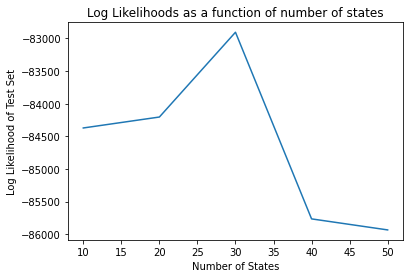

In [1042]:
lh_states = np.array([LH_10, LH_20, LH_30, LH_40, LH_50])
plt.plot(np.array([10,20,30,40,50]),lh_states)
plt.xlabel('Number of States')
plt.ylabel('Log Likelihood of Test Set')
plt.title('Log Likelihoods as a function of number of states')

# Part 2: State visualization

Using the model selected from cross-validation, plot the player location distributions for a few states.

Specifically, let $b_k \in \mathbb{R}^{20}$ and $Q_k \in \mathbb{R}^{20 \times 20}$ denote the estimated mean and covariance of state $k$. From this, you can compute the mean location of each player by reshaping $b_k$ into a 10x2 array (one row per player). Likewise, you can compute the marginal covariance of that player's location by extracting the corresponding 2x2 diagonal block from $Q_k$. 

Overlay Gaussian contours for the locations of the 10 players on the basketball court, using the provided `court.png` file as the background. For an accurate portrayal of the positions, set `extent = [0,100,0,50]` so that the image has the same `x` and `y` limits as the data. If you're using python, you can use the following starter code to get yourself started.

Plot this for a few states. Some might look more interesting than others.

In [1060]:
## selecting 30 states

mL_30_2, means_30_2, covs_30_2 = fit_hmm(event_data, 30)

/Users/ericgarc/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [1099]:




mean_vector_1 = np.reshape(means_30_2[0,:], (10,2))   
mean_vector_10 = np.reshape(means_30_2[9,:],(10,2))
mean_vector_20 = np.reshape(means_30_2[19,:],(10,2))  
mean_vector_30 = np.reshape(means_30_2[29,:],(10,2))

cov_matrix_1 = covs_30_2[0,:,:]
cov_matrix_10 = covs_30_2[9,:,:]
cov_matrix_20 = covs_30_2[19,:,:]
cov_matrix_30 = covs_30_2[29,:,:]

player_covs_1 = []
for i in range(10):
    cov = cov_matrix_1[2*i:2*i+2,2*i:2*i+2]
    player_covs_1.append(cov)

player_covs_10 = []
for i in range(10):
    cov = cov_matrix_10[2*i:2*i+2,2*i:2*i+2]
    player_covs_10.append(cov)

player_covs_20 = []
for i in range(10):
    cov = cov_matrix_20[2*i:2*i+2,2*i:2*i+2]
    player_covs_20.append(cov)
            
player_covs_30 = []
for i in range(10):
    cov = cov_matrix_30[2*i:2*i+2,2*i:2*i+2]
    player_covs_30.append(cov)
                    


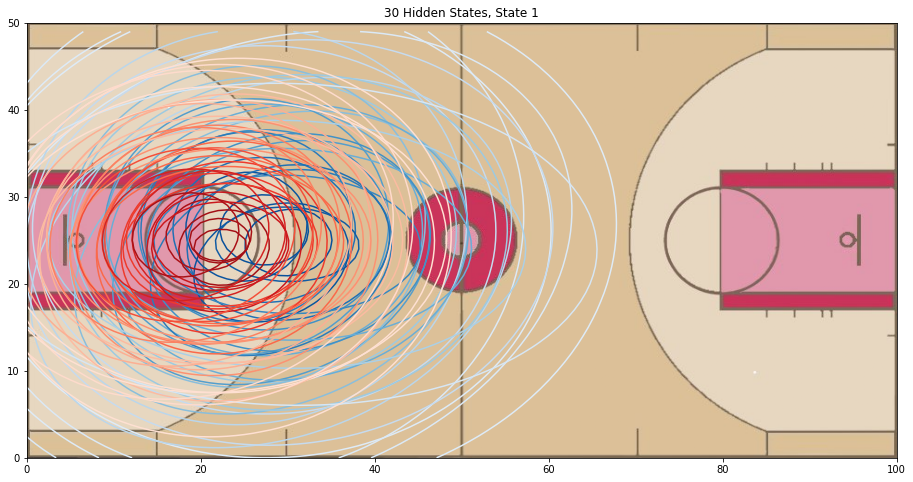

In [1097]:
delta = 1
x = np.arange(0, 100, delta)
y = np.arange(0, 50, delta)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

img = plt.imread('court.png')
fig, ax = plt.subplots(figsize = (16,8))
ax.imshow(img, extent = [0,100,0,50])

for i in range(10):
    current_mean = mean_vector_1[i,:]
    current_cov = player_covs_1[i]
    current_lh = multivariate_normal(current_mean, current_cov).pdf(pos)
    if i >=5:
        ax.contour(X, Y, current_lh.reshape(50,100), cmap = 'Reds')
    else:
        ax.contour(X, Y, current_lh.reshape(50,100), cmap = 'Blues')
'''
Insert your plotting code here
'''
plt.title("30 Hidden States, State 1")
plt.show()

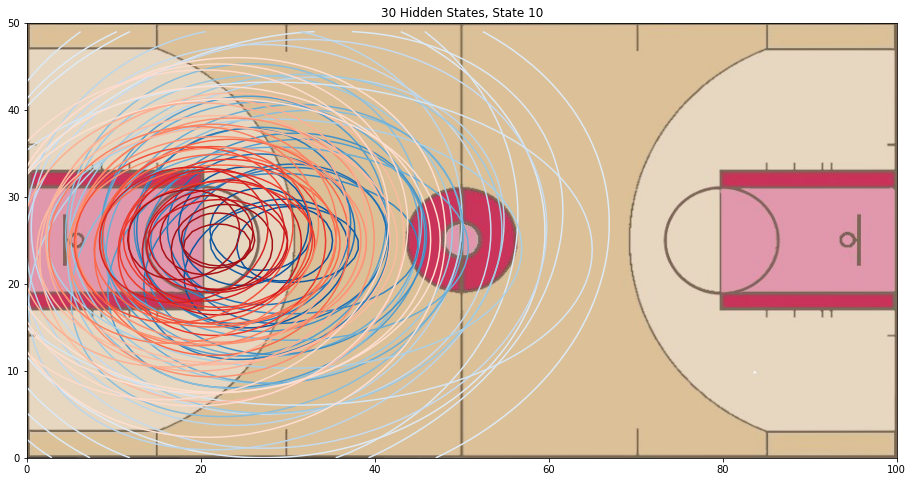

In [1100]:
delta = 1
x = np.arange(0, 100, delta)
y = np.arange(0, 50, delta)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

img = plt.imread('court.png')
fig, ax = plt.subplots(figsize = (16,8))
ax.imshow(img, extent = [0,100,0,50])

for i in range(10):
    current_mean = mean_vector_10[i,:]
    current_cov = player_covs_10[i]
    current_lh = multivariate_normal(current_mean, current_cov).pdf(pos)
    if i >=5:
        ax.contour(X, Y, current_lh.reshape(50,100), cmap = 'Reds')
    else:
        ax.contour(X, Y, current_lh.reshape(50,100), cmap = 'Blues')
'''
Insert your plotting code here
'''
plt.title("30 Hidden States, State 10")
plt.show()

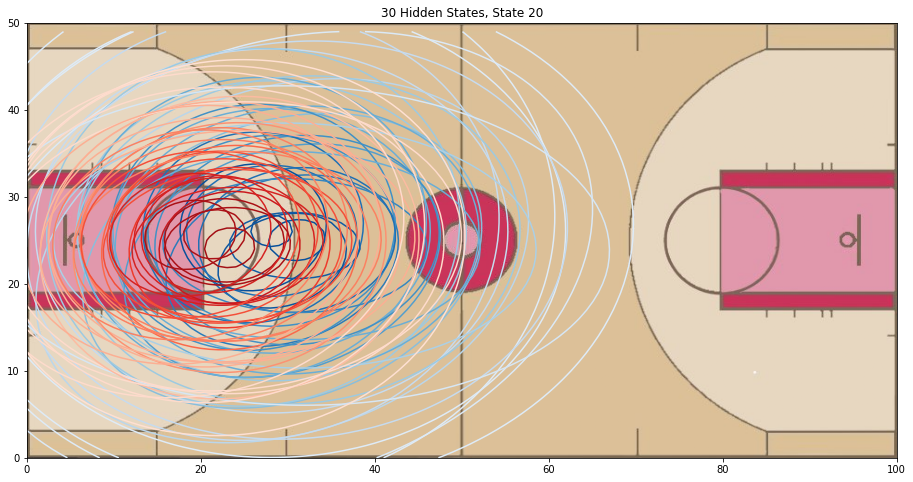

In [1101]:
delta = 1
x = np.arange(0, 100, delta)
y = np.arange(0, 50, delta)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

img = plt.imread('court.png')
fig, ax = plt.subplots(figsize = (16,8))
ax.imshow(img, extent = [0,100,0,50])

for i in range(10):
    current_mean = mean_vector_20[i,:]
    current_cov = player_covs_20[i]
    current_lh = multivariate_normal(current_mean, current_cov).pdf(pos)
    if i >=5:
        ax.contour(X, Y, current_lh.reshape(50,100), cmap = 'Reds')
    else:
        ax.contour(X, Y, current_lh.reshape(50,100), cmap = 'Blues')
'''
Insert your plotting code here
'''
plt.title("30 Hidden States, State 20")
plt.show()

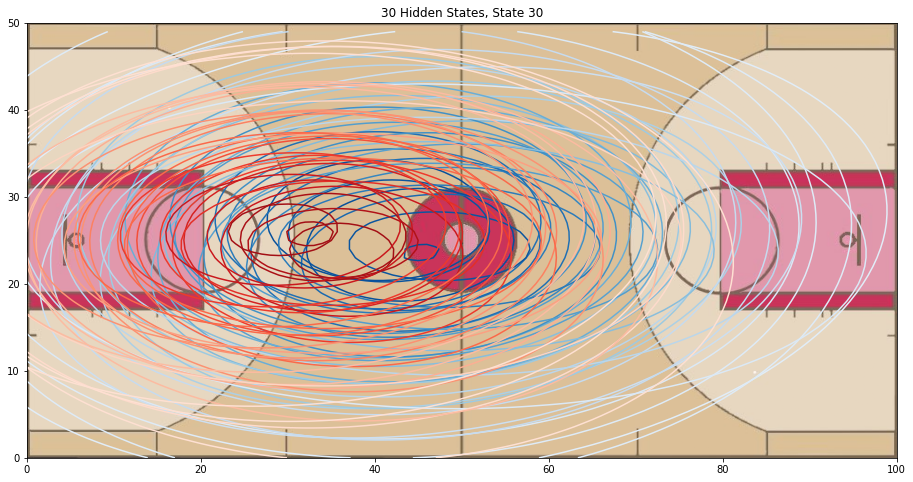

In [1102]:
delta = 1
x = np.arange(0, 100, delta)
y = np.arange(0, 50, delta)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

img = plt.imread('court.png')
fig, ax = plt.subplots(figsize = (16,8))
ax.imshow(img, extent = [0,100,0,50])

for i in range(10):
    current_mean = mean_vector_30[i,:]
    current_cov = player_covs_30[i]
    current_lh = multivariate_normal(current_mean, current_cov).pdf(pos)
    if i >=5:
        ax.contour(X, Y, current_lh.reshape(50,100), cmap = 'Reds')
    else:
        ax.contour(X, Y, current_lh.reshape(50,100), cmap = 'Blues')
'''
Insert your plotting code here
'''
plt.title("30 Hidden States, State 30")
plt.show()

# Part 3: Discussion Questions

### a) 

In a real basketball game, players do not move randomly, even among a specific latent state - there is some inherent smoothness in their decision making and hence movements. What adjustments would you make to the model to better incorporate these assumptions?

### Part 3a answer:

To account for the smoothness we could use a dynamic linear model that allows for a change in the parameters governing the distribution over time. The types of plays and maneuvers that players use change over the course of the game. We could also further classify movements and player states as to whether they are on offense or on defense. 

### b) 

In the data provided, we've symmetrized the data (so one team is only on offense in one direction, atypical to teams switching sides at the half), and players are consistently in the position that they play in relative to others. What would happen if for different plays, the players were randomly permuted?

Specifically, consider the following situations - what would happen if you tried to fit the model using the above calculated (fixed) number of latent states? What would happen if you did cross-validation again to recalculate the optimal number of latent states to use? 

### Part 3b answer:

The states that the game occurs in are very much defined by how the team is positioned relative to their own teammates and their opponents. Thus, if players were randomly permuted, the continuation into the next state would not be accurately guided by the permuted state. Using a model to calculate the new fixed number of states would not work as the states would not be static anymore. If we again used CV to test the optimal number of states, we would likely find that we would need more states as states that were previously deemed the same would now be classified as different due to player permutations.

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw7_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
